In [1]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
from time import time

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df= pd.DataFrame(data_dict)
POI_count = 0
name_list = data_dict.keys()
for person in name_list:
    POI_count += data_dict[person]['poi']    
print('Number of flagged Persons of Interest: %d' % POI_count)
print('Number of people without POI flag: %d' % (len(name_list) - POI_count))
print('Total Number of people: %d' % len(df.keys()))
#print("Number of features per person: %d"%len(list(data_dict[person].count))

Number of flagged Persons of Interest: 18
Number of people without POI flag: 128
Total Number of people: 146


In [2]:
df = pd.DataFrame.from_records(list(data_dict.values()))
persons = pd.Series(list(data_dict.keys()))

print df.head()

     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1               

In [3]:
total_index = data_dict.keys().index("TOTAL")
print "There are ", (total_index), "Total index"
travel_index = data_dict.keys().index("THE TRAVEL AGENCY IN THE PARK")
print "There are ", (travel_index), "travel agency in the park"
print('Number of flagged Persons of Interest: %d' % len(data_dict['SKILLING JEFFREY K'].keys()))
print "LOCKHART EUGENE E ", data_dict['LOCKHART EUGENE E']

There are  104 Total index
There are  101 travel agency in the park
Number of flagged Persons of Interest: 21
LOCKHART EUGENE E  {'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'exercised_stock_options': 'NaN', 'bonus': 'NaN', 'restricted_stock': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


In [4]:
NA_salary = []
for x in data_dict.values():
    if x['salary'] != 'NaN':
        NA_salary.append(x['salary'])
len(NA_salary),"have a quantified salary from this dataset"

(95, 'have a quantified salary from this dataset')

In [5]:
email_array = []
for x in data_dict.values():
    if x['email_address'] == 'NaN':
        email_array.append(x['email_address'])
        
print len(email_array), "has email address"

35 has email address


In [6]:
# Convert to numpy nan
df.replace(to_replace='NaN', value=np.nan, inplace=True)

# Count number of NaN's for columns
print df.isnull().sum()

# DataFrame dimeansion
print df.shape

nandf = df.isnull().sum()

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 35
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64
(146, 21)


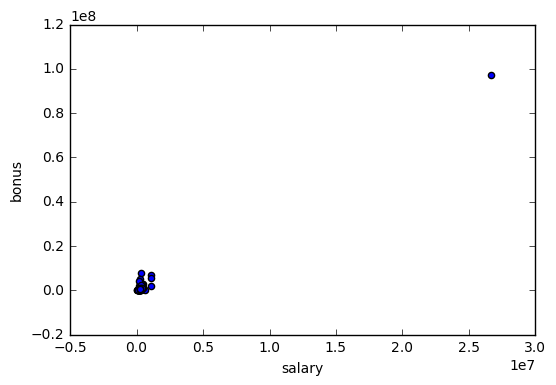

In [7]:
%matplotlib inline
features = ["salary", "bonus"]
#data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)
### plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [8]:
### Task 2: Remove outliers
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features_list) 

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
### print top 4 salaries
print outliers_final

for name in outliers_final:
    if data_dict[name[0]]['poi'] ==1:
        print name[0]
        
import csv
df.to_csv('enron_data.csv')


[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]
SKILLING JEFFREY K
LAY KENNETH L


In [9]:
def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features



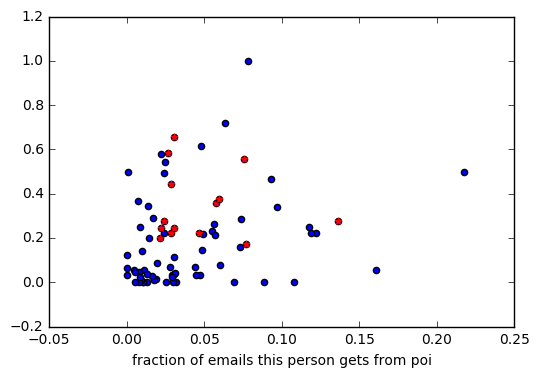

In [10]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
poi_sender_fract=dict_to_list("from_poi_to_this_person","to_messages")
poi_recipient_fract=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["poi_sender_fract"]=poi_sender_fract[count]
    data_dict[i]["poi_recipient_fract"]=poi_recipient_fract[count]
    count +=1

    
features_list = ["poi", "poi_sender_fract", "poi_recipient_fract"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()

In [11]:

from feature_format import featureFormat
from feature_format import targetFeatureSplit

my_features = features_list + [
'shared_receipt_with_poi',
'expenses',
'loan_advances',
'long_term_incentive',
'other',
 'restricted_stock',
'restricted_stock_deferred',
'deferral_payments',
 'deferred_income',
'salary',
'total_stock_value',
'exercised_stock_options',
'total_payments',
'bonus']


features_list = ["poi", "salary", "bonus", "poi_sender_fract", "poi_recipient_fract",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(data_dict, features_list)

labels, features = targetFeatureSplit(data)

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = scaler.fit_transform(features)

k_best = SelectKBest(k=5)
k_best.fit(features, labels)

results_list = zip(k_best.get_support(), my_features[1:], k_best.scores_)
results_list = sorted(results_list, key=lambda x: x[2], reverse=True)
print "K-best features:", results_list

## 5 best features chosen by SelectKBest
my_features = features_list + ['exercised_stock_options',
'total_stock_value',
'bonus',
 'salary',
'poi_sender_fract']

data = featureFormat(my_dataset, my_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

K-best features: [(True, 'salary', 25.097541528735508), (True, 'deferral_payments', 24.467654047526398), (True, 'poi_recipient_fract', 21.060001707536582), (True, 'poi_sender_fract', 18.575703268041824), (True, 'expenses', 16.641707070469), (False, 'restricted_stock_deferred', 11.595547659731226), (False, 'total_stock_value', 10.072454529369441), (False, 'total_payments', 9.346700791051429), (False, 'long_term_incentive', 8.8667215371077752), (False, 'exercised_stock_options', 8.7464855321290802), (False, 'other', 7.2427303965360172), (False, 'deferred_income', 6.2342011405067357), (False, 'shared_receipt_with_poi', 3.2107619169667658), (False, 'bonus', 2.1076559432760891), (False, 'loan_advances', 0.21705893033950577), (False, 'restricted_stock', 0.064984311723709984)]


In [12]:
features_list = ["poi", "salary", "bonus", "poi_sender_fract", "poi_recipient_fract",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(data_dict, features_list)

### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)


from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]])

accuracy 0.733333333333
Decision tree algorithm time: 0.006 s
Feature Ranking: 
1 feature salary (0.21641984716)
2 feature bonus (0.158290984378)
3 feature poi_sender_fract (0.14622972935)
4 feature poi_recipient_fract (0.14139568871)
5 feature deferral_payments (0.118337314859)
6 feature total_payments (0.0747826086957)
7 feature loan_advances (0.0534161490683)
8 feature restricted_stock_deferred (0.0534161490683)
9 feature deferred_income (0.0377115287109)
10 feature total_stock_value (0.0)
11 feature expenses (0.0)
12 feature exercised_stock_options (0.0)
13 feature long_term_incentive (0.0)
14 feature shared_receipt_with_poi (0.0)
15 feature restricted_stock (0.0)
16 feature director_fees (0.0)


In [13]:
from sklearn.metrics import accuracy_score
features_list = ["poi", "poi_sender_fract", "poi_recipient_fract", "shared_receipt_with_poi"]
### try Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print accuracy

print "NB algorithm time:", round(time()-t0, 3), "s"

NameError: name 'GaussianNB' is not defined

In [ ]:
### use manual tuning parameter min_samples_split
clf = DecisionTreeClassifier(min_samples_split=5)
print clf

In [ ]:
### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
#features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", 'shared_receipt_with_poi']
features_list = ["poi", "poi_sender_fract", "poi_recipient_fract", "shared_receipt_with_poi"]

### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print 'accuracy before tuning ', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"


### use manual tuning parameter min_samples_split
t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print "Validating algorithm:"
print "accuracy after tuning = ", acc

# function for calculation ratio of true positives
# out of all positives (true + false)

from sklearn.metrics import precision_score

print 'precision = ', precision_score(labels_test,pred)

# function for calculation ratio of true positives
# out of true positives and false negatives
from sklearn.metrics import recall_score

print 'recall = ', recall_score(labels_test,pred)


### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

In [ ]:
import pickle
import sys
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import StratifiedShuffleSplit
from feature_format import featureFormat, targetFeatureSplit

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    #Added min max scaler here
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    features = min_max_scaler.fit_transform(features)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            else:
                true_positives += 1
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    pickle.dump(clf, open(CLF_PICKLE_FILENAME, "w") )
    pickle.dump(dataset, open(DATASET_PICKLE_FILENAME, "w") )
    pickle.dump(feature_list, open(FEATURE_LIST_FILENAME, "w") )

def load_classifier_and_data():
    clf = pickle.load(open(CLF_PICKLE_FILENAME, "r") )
    dataset = pickle.load(open(DATASET_PICKLE_FILENAME, "r") )
    feature_list = pickle.load(open(FEATURE_LIST_FILENAME, "r"))
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()

In [ ]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [ ]:
import pickle
import sys
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import StratifiedShuffleSplit
from feature_format import featureFormat, targetFeatureSplit

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    #Added min max scaler here
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    features = min_max_scaler.fit_transform(features)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            else:
                true_positives += 1
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    pickle.dump(clf, open(CLF_PICKLE_FILENAME, "w") )
    pickle.dump(dataset, open(DATASET_PICKLE_FILENAME, "w") )
    pickle.dump(feature_list, open(FEATURE_LIST_FILENAME, "w") )

def load_classifier_and_data():
    clf = pickle.load(open(CLF_PICKLE_FILENAME, "r") )
    dataset = pickle.load(open(DATASET_PICKLE_FILENAME, "r") )
    feature_list = pickle.load(open(FEATURE_LIST_FILENAME, "r"))
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()

In [ ]:
ref: https://www.kaggle.com/forums/f/15/kaggle-forum/t/12611/methodological-ml-dispute-with-a-udacity-teacher-could-you-help-me-understanding
        http://scikit-learn.org/stable/modules/feature_selection.html
            
        